Model: https://www.kaggle.com/code/theeyeschico/vegetable-classification-using-transfer-learning/notebook <br>
Dataset: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset

<h1>Idea behind using Transfer learning</h1> 

- Instead of training a deep network from scratch, we can actually take a pre-trained network and use it for a different task as learning of a new task relies on the previously learned tasks.
- Assisting in image analysis and classification tasks including object detection with good accuracy.
- We will use InceptionV3 which is a network already trained on more than a million images from the ImageNet database

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from PIL import Image 
from PIL import ImageEnhance
from skimage.io import imread
import matplotlib.pyplot as plt

import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix

from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dense, Dropout

K.clear_session()

# <b>1. Loading the dataset</b>
<h3> Let's define the path to base directories used in the project </h3>

In [2]:
dataset='C:\\Users\\shani\\OneDrive - Singapore Institute Of Technology\\Y1 T2\\Computer Networks\\Project\\veg\\Vegetable Images'

train_folder = os.path.join(dataset,"train")
test_folder = os.path.join(dataset,"validation")
validation_folder = os.path.join(dataset,"test")

<h3>Counting number of images in a folder. (test set in our case)</h2>

In [3]:
def count_files(rootdir):
    '''counts the number of files in each subfolder in a directory'''
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print("There are " + str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files in " + \
            str(path.name))
 
count_files(os.path.join(test_folder))

There are 200 files in Bitter_Gourd
There are 200 files in Bottle_Gourd
There are 200 files in Brinjal
There are 200 files in Broccoli
There are 200 files in Cabbage
There are 200 files in Capsicum
There are 200 files in Carrot
There are 200 files in Cauliflower
There are 200 files in Cucumber
There are 200 files in Papaya
There are 200 files in Potato
There are 200 files in Pumpkin
There are 200 files in Radish
There are 200 files in Tomato


# <b>2. Image Processing</b>
<h3> The goal of image processing is improvement of pictorial information for human interpretation. Basic manipulation and filtering can lead to increased understanding for feature extraction as well. </h3><br>
<h3><b><span style="color:green">Here we can select any vegetable of our choice and a random image from the class is displayed with comparison to a processed image.</span></b></h3>


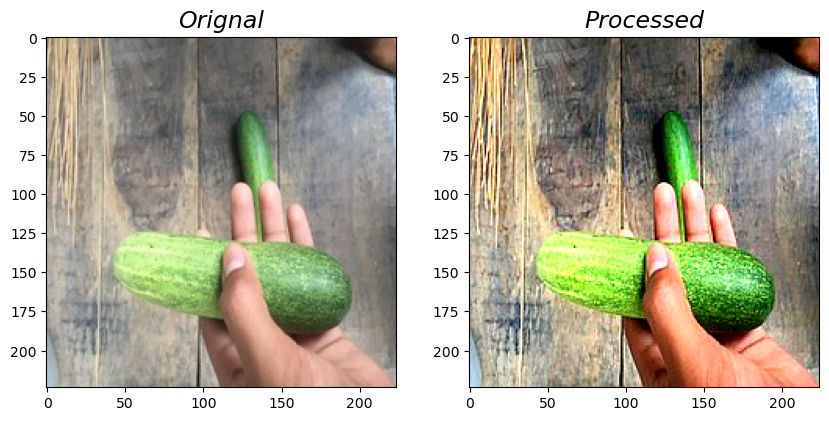

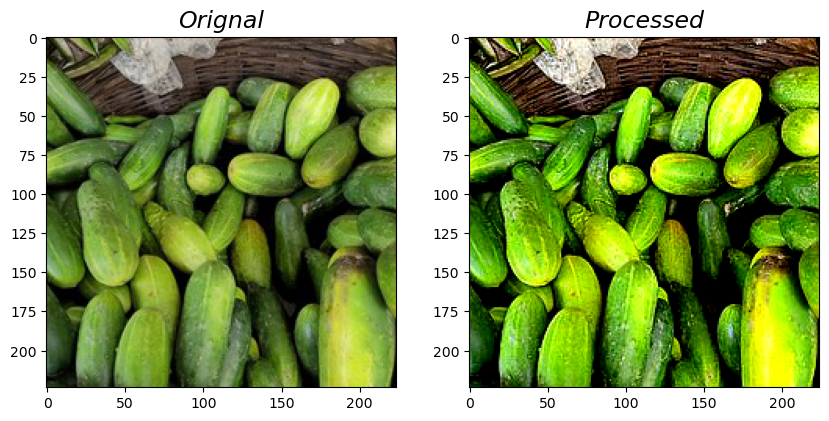

In [4]:
image_folder="Cucumber"  # The vegetable you want to display
number_of_images=2       # Number of images to display

def Preprocess():
    j=1
    for i in range(number_of_images):
    
        folder = os.path.join(test_folder,image_folder)
        a=random.choice(os.listdir(folder))

        image=Image.open(os.path.join(folder,a))
        image_duplicate=image.copy()
        plt.figure(figsize=(10,10))

        plt.subplot(number_of_images,2,j)
        plt.title(label='Orignal', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image)
        j+=1

        image1=ImageEnhance.Color(image_duplicate).enhance(1.35)
        image1=ImageEnhance.Contrast(image1).enhance(1.45)
        image1=ImageEnhance.Sharpness(image1).enhance(2.5)
        
        plt.subplot(number_of_images,2,j)
        plt.title(label='Processed', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image1)
        j+=1
        
Preprocess()

<h3> We increased the color saturation, contrast and finally sharpened the image for drawing texture and viewer focus. The image after processing looks appealing and brighter</h3>

# <span style="color:blue"><b> 3. Data Visualization (EDA)</b></span>
<hr>
<h2> We can start exploring the dataset and visualize any class label <i>(for instance, Capsicum)</i>. You can choose any vegetable to visualize the images of that class. Changing rows and columns variable also results in different format positioning of matplotlib. </h2>

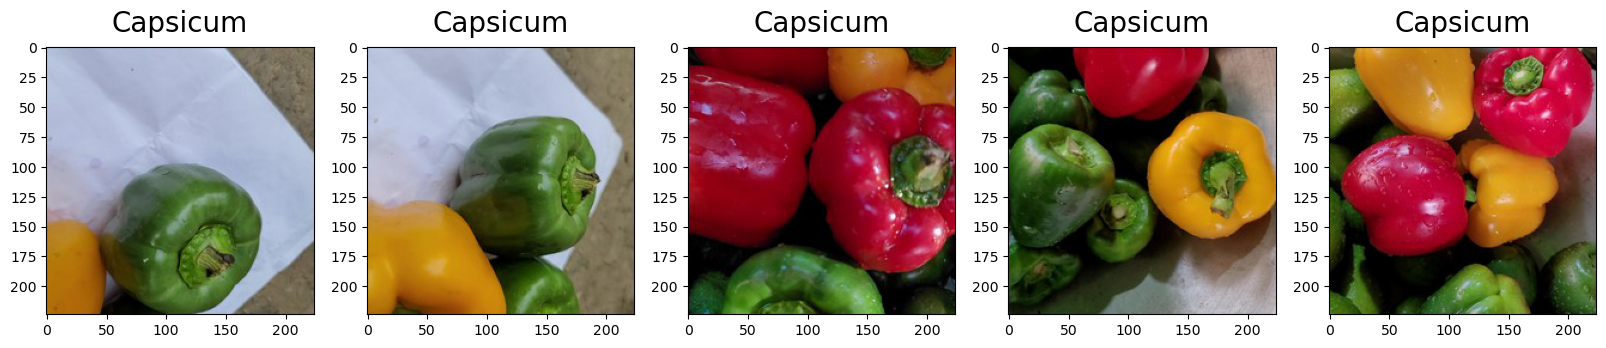

In [5]:
select_vegetable="Capsicum"
rows,columns = 1,5

display_folder=os.path.join(train_folder,select_vegetable)
total_images=rows*columns
fig=plt.figure(1, figsize=(20, 10))

for i,j in enumerate(os.listdir(display_folder)):      
    
    img = plt.imread(os.path.join(train_folder,select_vegetable,j))
    fig=plt.subplot(rows, columns, i+1)
    fig.set_title(select_vegetable, pad = 11, size=20)
    plt.imshow(img)
    
    if i==total_images-1:
        break

<h2> Now let's visualize the whole dataset by picking a random image from each class inside training dataset. </h2>

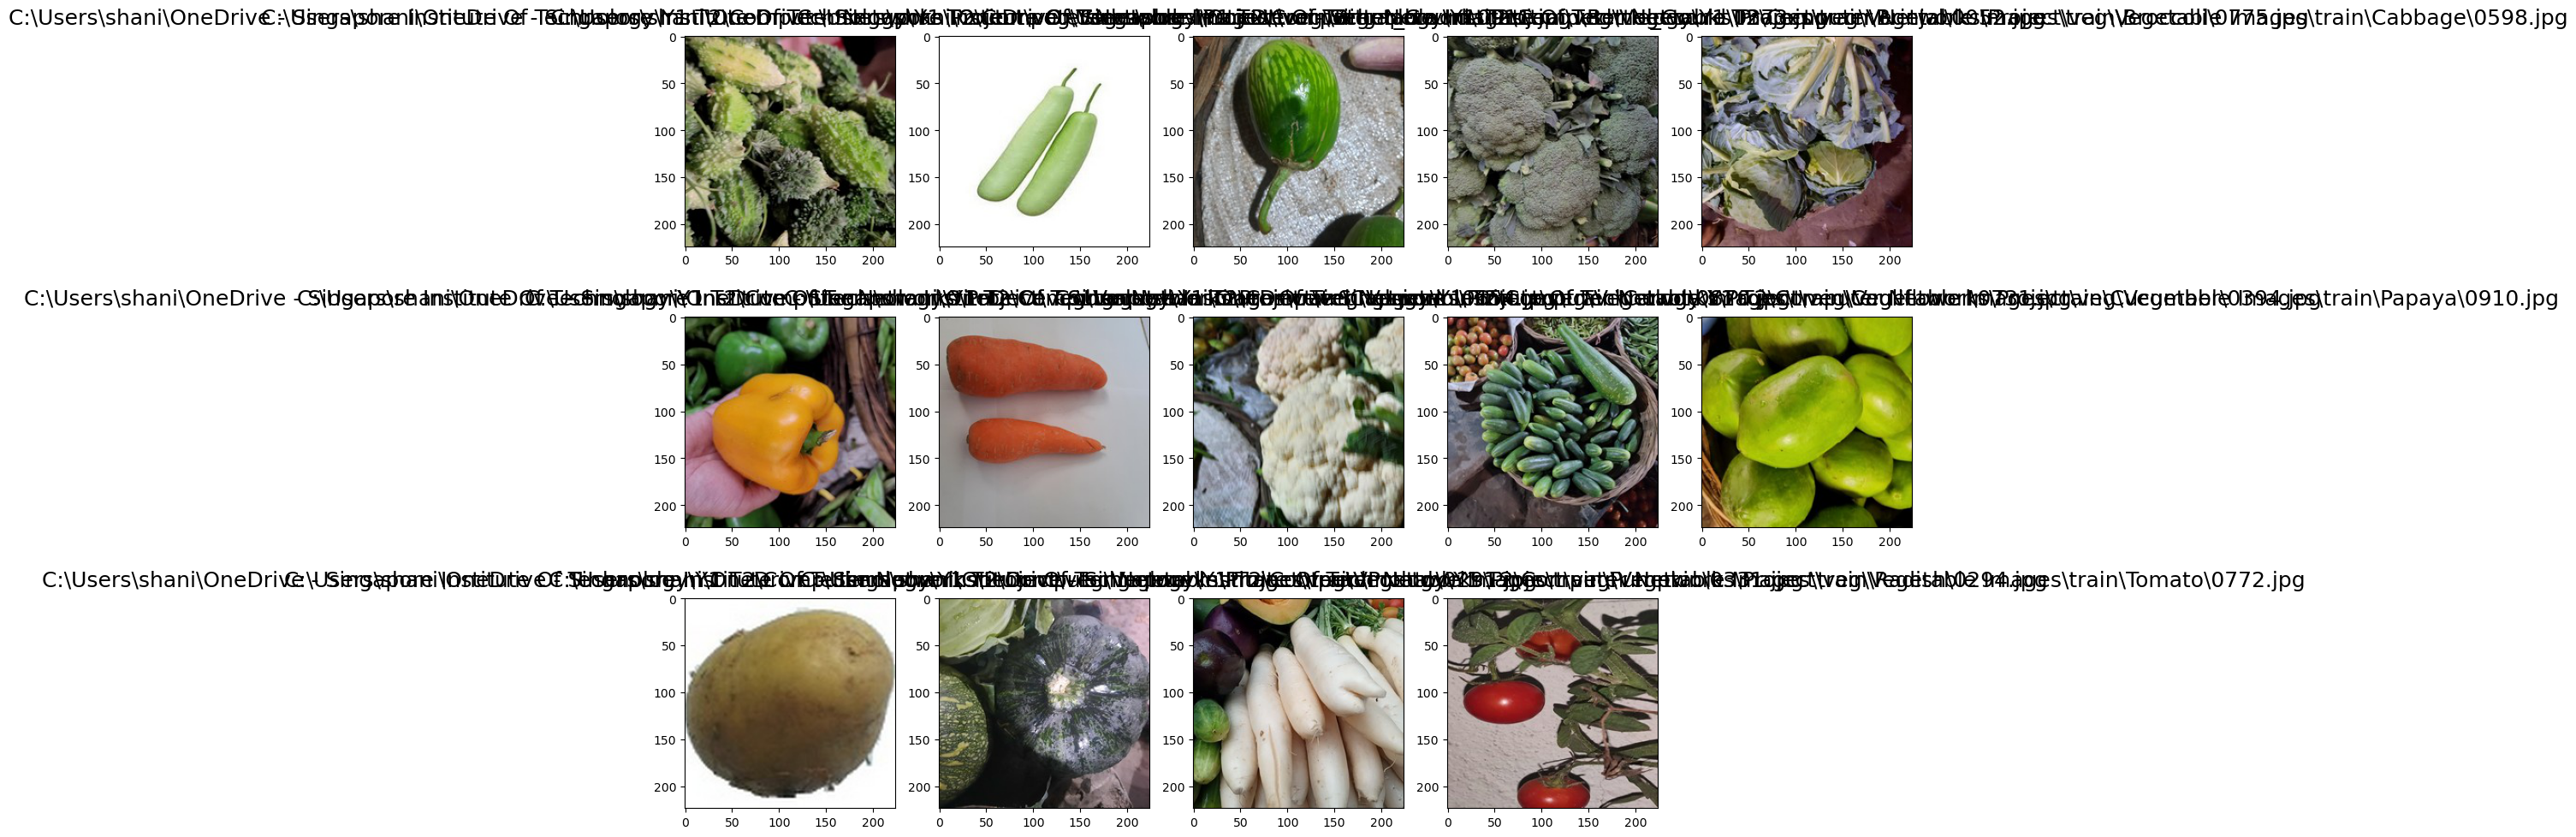

In [6]:
images = []

for food_folder in sorted(os.listdir(train_folder)):
    food_items = os.listdir(train_folder + '/' + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_folder,food_folder,food_selected))
                                     
fig=plt.figure(1, figsize=(15, 10))

for subplot,image_ in enumerate(images):
    category=image_.split('/')[0]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(3, 5, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)
    
plt.tight_layout()

<span style="font-size:18px;color:green"><b>There are 15 vegetables (output classes) and one random image from each class helps in determining basic outlook of dataset and what picture quality along with different metric are visible. So far, So Good! </b></span>

# <span style="color:blue"><b>4. Model Building</b></span>
<hr>
<h2> Let's start building the transfer learning network to train our model using <u>InceptionV3</u>. </h2>

In [12]:
IMAGE_SIZE = [224, 224]

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False

x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

prediction = Dense(14, activation='softmax')(x)

model = Model(inputs=inception.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

# <span style="color:blue"><b>5. Model Training</b></span>
<hr>

In [13]:
train_datagen = image.ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(
    train_folder,
    target_size = (224, 224),
    batch_size = 64,
    class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
    test_folder, 
    target_size = (224, 224),
    batch_size = 64, 
    class_mode = 'categorical')

Found 14000 images belonging to 14 classes.
Found 2800 images belonging to 14 classes.


In [14]:
class_map = training_set.class_indices
class_map

{'Bitter_Gourd': 0,
 'Bottle_Gourd': 1,
 'Brinjal': 2,
 'Broccoli': 3,
 'Cabbage': 4,
 'Capsicum': 5,
 'Carrot': 6,
 'Cauliflower': 7,
 'Cucumber': 8,
 'Papaya': 9,
 'Potato': 10,
 'Pumpkin': 11,
 'Radish': 12,
 'Tomato': 13}

In [15]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/5
219/219 [==============================] - 393s 2s/step - loss: 0.2600 - accuracy: 0.9190 - val_loss: 0.0529 - val_accuracy: 0.9811
Epoch 2/5
219/219 [==============================] - 316s 1s/step - loss: 0.0746 - accuracy: 0.9766 - val_loss: 0.0397 - val_accuracy: 0.9857
Epoch 3/5
219/219 [==============================] - 309s 1s/step - loss: 0.0454 - accuracy: 0.9853 - val_loss: 0.0217 - val_accuracy: 0.9936
Epoch 4/5
219/219 [==============================] - 302s 1s/step - loss: 0.0344 - accuracy: 0.9895 - val_loss: 0.0273 - val_accuracy: 0.9914
Epoch 5/5
219/219 [==============================] - 310s 1s/step - loss: 0.0369 - accuracy: 0.9883 - val_loss: 0.0208 - val_accuracy: 0.9943


## Saving the Model

In [16]:
model.save('model_inceptionV3_epoch5.h5')

## Accuracy and Loss Curves

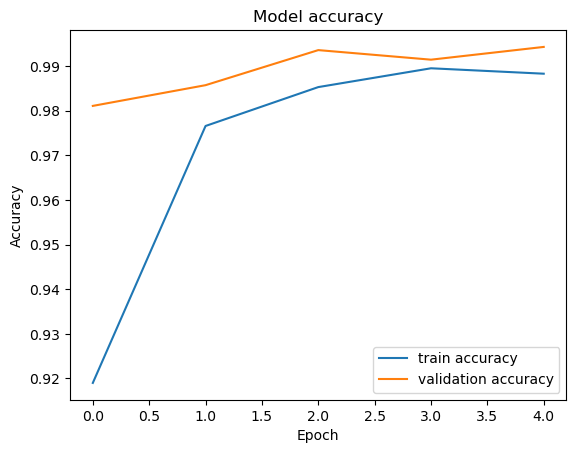

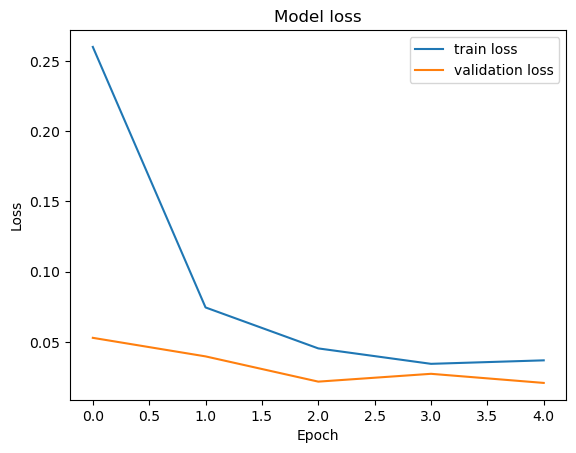

In [17]:
def plot_accuracy(history):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()
    
def plot_loss(history):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()
    
plot_accuracy(r)
plot_loss(r)

## Model Layers

In [18]:
print("Total layers in the model : ",len(model.layers),"\n")

layers = [layer.output for layer in model.layers[0:]]
layer_names = []
for layer in model.layers[0:]: 
    layer_names.append(layer.name)
    
print("First layer : ", layer_names[0])
print("InceptionV3 layers : Layer 2 to Layer 311")
print("Our fine tuned layers : ", layer_names[311:314])
print("Final Layer : ", layer_names[314])


Total layers in the model :  315 

First layer :  input_2
InceptionV3 layers : Layer 2 to Layer 311
Our fine tuned layers :  ['global_average_pooling2d_1', 'dense_2', 'dropout_1']
Final Layer :  dense_3


# <b><span style="color:blue">6. Predictions</span></b>
<hr>
<h2> Loading the model </h2>

In [19]:
K.clear_session()
path_to_model='./model_inceptionV3_epoch5.h5'
print("Loading the model..")
model = load_model(path_to_model)
print("Done!")

Loading the model..
Done!


## Testing the model on validation set

In [32]:
validation_data_dir = 'C:\\Users\\shani\\OneDrive - Singapore Institute Of Technology\\Y1 T2\\Computer Networks\\Project\\veg\\Vegetable Images\\test'

validation_datagen = image.ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical')

scores = model.evaluate(validation_generator)
print("Test Accuracy: {:.3f}".format(scores[1]))

Found 2800 images belonging to 14 classes.
44/44 [==============================] - 49s 1s/step - loss: 0.0145 - accuracy: 0.9957
Test Accuracy: 0.996


<h2> Functions to predict the output of our model

In [54]:
category={
    0: 'Bitter_Gourd', 1: 'Bottle_Gourd', 2 : 'Brinjal', 3: "Broccoli", 4: 'Cabbage', 5: 'Capsicum', 6: 'Carrot', 7: 'Cauliflower',
    8: 'Cucumber', 9: 'Papaya', 10: 'Potato', 11: 'Pumpkin', 12 : "Radish", 13: "Tomato"
}

def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(category[index]))
    plt.imshow(img_array)

def predict_label(filename,model):
    img_ = image.load_img(filename, target_size=(224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    index = np.argmax(prediction)
    
    return category[index]
    
def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1
    
    true=filedir.split('/')[-1]
    
    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))
        
    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(224, 224))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)
        
        pred=category.get(index)
        if pred==true:
            pos+=1

    acc=pos/total_images
    print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,orignal=true))

- <h3> Single image prediction </h3>

1/1 [==============================] - 0s 47ms/step


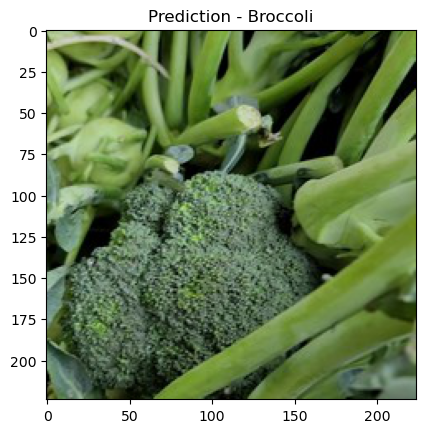

In [58]:
predict_image(os.path.join(validation_folder,'Broccoli/1098.jpg'),model)

In [55]:
prediction = predict_label(os.path.join(validation_folder,'Cauliflower/1064.jpg'),model)
print(prediction)

1/1 [==============================] - 0s 47ms/step
Cauliflower


### Convert to TFLite for Edge devices

In [ ]:
# Convert the model to TensorFlow Lite format for deployment on edge devices
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [60]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [3]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[0.01740785 0.0228133  0.00894746 0.00429493 0.00762352 0.00210851
  0.00708702 0.01321984 0.00186691 0.01520664 0.00833571 0.01222064
  0.00879395 0.8700737 ]]


- <h3> Validation directory accuracy prediction </h3>

In [ ]:
for i in os.listdir(validation_folder):
    predict_dir(os.path.join(validation_folder,i),model)

# <b><span style="color:blue">7. Evaluation</span></b>
<hr> 
<h2> Loading the model </h2>

## Confusion Matrix for evaluating the performance of our classification model.

In [ ]:
def labels_confusion_matrix(validation_folder):
    
    folder_path=validation_folder
    
    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i
    
    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):
        
        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]
        
        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(224,224))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0) 
            img_processed /= 255.
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)
            
    return (real,predicted)

def print_confusion_matrix(real,predicted):
    total_output_labels = 15
    cmap="turbo"
    cm_plot_labels = [i for i in range(15)]
    
    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.2) # for label size
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap) # font size

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

In [ ]:
y_true,y_pred=labels_confusion_matrix(validation_folder)
print_confusion_matrix(y_true,y_pred)

## Visualizing all incorrect images predicted for a particular vegetable category by our classifier. 

In [ ]:
def wrong_input_capture(test_category):
    
    a=os.path.basename(test_category)
    wrong_array=[]
    
    for i in os.listdir(test_category):
        
        imggg=os.path.join(test_category,i)
        
        img_ = image.load_img(imggg, target_size=(224, 224))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.
        prediction = model.predict(img_processed)
        
        index = np.argmax(prediction)
        pred=category.get(index)
        
        if not pred==a:
            wrong_array.append((imggg,pred))
            
    return wrong_array
    
def visualize_wrong_input(images):
    
    fig=plt.figure(1, figsize=(20, 25))
    total_images=len(images)
    rows=math.ceil(float(total_images/3))
    for subplot,(image_path,predicted) in enumerate(images):
        img = plt.imread(image_path)
        fig=plt.subplot(rows, 3, subplot+1)
        fig.set_title("Predicted - {}".format(predicted), pad = 10,size=18)
        plt.imshow(img)
        
    plt.tight_layout()

In [ ]:
vegetable="Broccoli"
path=os.path.join(validation_folder,vegetable)
images= wrong_input_capture(path)
visualize_wrong_input(images)